# Importing libraries

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import imdb 


from tensorflow.keras.preprocessing import sequence
# import nltk
from sklearn.model_selection import train_test_split
import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sachinsinghal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sachinsinghal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
from tensorflow.keras.datasets import imdb
import pandas as pd
import numpy as np
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras
from sklearn.model_selection import train_test_split

# Reading the scrapped StockTwits dataset

In [162]:
df = pd.read_csv('/Users/sachinsinghal/Downloads/StockTwits_Tesla_Mar-Jun.csv')

In [164]:
df=df[['body','senti','created_at']]

# Pre processing the dataset

## Removing punctuations

In [132]:
test = df[df['senti']==" "]
data = df[df['senti']!=" "]

#Lengh of the text
data['length']=data['body'].apply(lambda x: len(x.split()))

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
data['body']= data['body'].apply(lambda x : remove_tags(x))

def remove_tags(string):
    result = re.sub(r'[^\w\s]', ' ', string)
    return result
data['body']= data['body'].apply(lambda x : remove_tags(x))

<ipython-input-132-ad86b1a21a28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length']=data['body'].apply(lambda x: len(x.split()))
<ipython-input-132-ad86b1a21a28>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['body']= data['body'].apply(lambda x : remove_tags(x))
<ipython-input-132-ad86b1a21a28>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

## Filtering out tweets less than length of 3 and replacing @TSLA with blanks

In [133]:
data_1 = data[data['length']>3]

data_1['body'] = data_1['body'].apply(lambda x:x.replace('@TSLA',''))

<ipython-input-133-77b3168da5b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['body'] = data_1['body'].apply(lambda x:x.replace('@TSLA',''))


## Filtering out the tweets posted between 9am to 4pm for average sentiment prediction

In [165]:
df['created_at'] = df['created_at'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00'))
df['Hour'] = df['created_at'].apply(lambda x:x.hour)
df['Month'] = df['created_at'].apply(lambda x:x.month)
df['weekday'] = df['created_at'].apply(lambda x: x.weekday())
df['day'] = df['created_at'].apply(lambda x: x.day)

df_current = df[(df['weekday'] < 5) & (df['Hour'] > 8)  & (df['Hour'] < 16)]

## Removing punctuations


In [166]:
df_current.drop(['senti','Hour','Month','weekday'],axis=1, inplace=True)

df_current['length']=df_current['body'].apply(lambda x: len(x.split()))
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df_current['body']= df_current['body'].apply(lambda cw : remove_tags(cw))
def remove_tags(string):
    result = re.sub(r'[^\w\s]', ' ', string)
    return result
df_current['body']= df_current['body'].apply(lambda cw : remove_tags(cw))
df_current = df_current[df_current['length']>3]
df_current['body'] = df_current['body'].apply(lambda x:x.replace('BTC.X',''))

/Users/sachinsinghal/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-166-04bc749a8be7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['length']=df_current['body'].apply(lambda x: len(x.split()))
<ipython-input-166-04bc749a8be7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

# Tokenization and splitting the dataset 

In [236]:
data_1['body'] = data_1['body'].str.lower()

reviews_tokenized = data_1['body'].apply(nltk.word_tokenize).tolist()
reviews_list=[]
for row in reviews_tokenized:
    reviews_list.append([token.lower() for token in row if token.isalpha() if len(token)>1])

X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, data_1['senti'], test_size=0.2, random_state = 150)

## Converting Bullish and bearish labels to numerics


In [237]:
Y_train = np.array(list(map(lambda x: 1 if x=="Bullish" else 0, Y_train)))
Y_test = np.array(list(map(lambda x: 1 if x=="Bullish" else 0, Y_test)))

## Initializing a tokenizer

In [238]:
#Create dictionary to store 5000 most frequent words 
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

In [239]:
#
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxLen = 50
batch_size = 32

# LSTM model

In [232]:
model = keras.Sequential()
# Embedding layer turns vectors of integers into dense real vectors of fixed size
model.add(layers.Embedding(max_features, 64))
# model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
# model.add(Dropout(0.2))
model.add(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer='l2'))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [233]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          1280000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [245]:
#Get index of the tweets from the dictionary 
X_train_indices = tokenizer.texts_to_sequences(X_train)

#Pad to get the length=max_length 
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(99064, 50)

In [145]:
EPOCHS = 32
BATCH = 128

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit(X_train_indices, Y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_split=0.2,
          verbose = 1,
          callbacks = [early_stop])

Epoch 1/32
620/620 [==============================] - 104s 165ms/step - loss: 0.5993 - accuracy: 0.7331 - val_loss: 0.5059 - val_accuracy: 0.7829
Epoch 2/32
620/620 [==============================] - 176s 284ms/step - loss: 0.4914 - accuracy: 0.7888 - val_loss: 0.4728 - val_accuracy: 0.7928
Epoch 3/32
620/620 [==============================] - 204s 329ms/step - loss: 0.4613 - accuracy: 0.8048 - val_loss: 0.5080 - val_accuracy: 0.8022
Epoch 4/32
620/620 [==============================] - 200s 323ms/step - loss: 0.4406 - accuracy: 0.8145 - val_loss: 0.4622 - val_accuracy: 0.8145
Epoch 5/32
620/620 [==============================] - 180s 290ms/step - loss: 0.4299 - accuracy: 0.8207 - val_loss: 0.4823 - val_accuracy: 0.8111
Epoch 6/32
620/620 [==============================] - 201s 324ms/step - loss: 0.4188 - accuracy: 0.8265 - val_loss: 0.4501 - val_accuracy: 0.8160
Epoch 7/32
620/620 [==============================] - 183s 295ms/step - loss: 0.4077 - accuracy: 0.8343 - val_loss: 0.4381 -

In [241]:
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
X_test_indices.shape

(24766, 50)

In [147]:
_, acc = model.evaluate(X_test_indices, Y_test, batch_size=64, verbose = 0)
print("Testing set accuracy: {:.2f}%".format(acc*100))

Testing set accuracy: 82.70%


# Tokenizing the stocktwits scrapped data to be fed into the trained model

In [167]:
df_current['body'] = df_current['body'].str.lower()

reviews_tokenized = df_current['body'].apply(nltk.word_tokenize).tolist()
current_data=[]
for row in reviews_tokenized:
    current_data.append([token.lower() for token in row if token.isalpha() if len(token)>1])

In [168]:
X_test_indices = tokenizer.texts_to_sequences(current_data)
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
X_test_indices.shape

(69007, 50)

## Using the trained model to predict the sentiment score on scrapped tweets


In [183]:
def add_score_predictions(df_new, X_test_indices):

    df_new['sentiment score'] = 0

    #     reviews_list_idx = pad_sequences(reviews_list_idx, maxlen=maxLen, padding='post')

    review_preds = model.predict(X_test_indices)

    df_new['sentiment score'] = review_preds

    pred_sentiment = np.array(list(map(lambda x : 1 if x > 0.5 else 0 ,review_preds)))

    df_new['predicted sentiment'] = 0

    df_new['predicted sentiment'] = pred_sentiment

    return df_new


In [186]:
data = add_score_predictions(df_current, X_test_indices)

In [173]:
data['date'] = data['created_at'].apply(lambda x: x.date())
data.groupby(['date']).aggregate({'sentiment score':np.average})

,sentiment score
date,
2021-03-05,0.681795
2021-03-08,0.726278
2021-03-09,0.757621
2021-03-10,0.751788
2021-03-11,0.759723
...,...
2021-06-21,0.749216
2021-06-22,0.759940
2021-06-23,0.806856


In [187]:
data['predicted sentiment'].value_counts()

1    55126
0    13881
Name: predicted sentiment, dtype: int64

In [189]:
import matplotlib.pyplot as plt

## Plotting the histogram of the sentiment score

(array([ 3454.,  4035.,  2102.,  2771.,  1544.,  4685.,  3572.,  6944.,
        10370., 29530.]),
 array([0.00393873, 0.10338531, 0.2028319 , 0.3022785 , 0.40172505,
        0.50117165, 0.60061824, 0.70006484, 0.7995114 , 0.89895797,
        0.99840456], dtype=float32),
 <BarContainer object of 10 artists>)

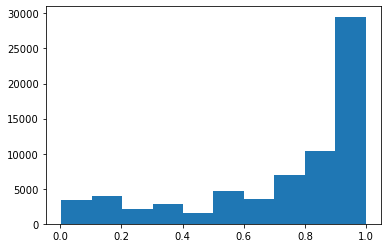

In [190]:
plt.hist(data['sentiment score'])

# Importing the ticker data from Yahoo finance

In [205]:
import yfinance as yf

#define the ticker symbol
tickerSymbol = 'TSLA'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2021-3-1', end='2021-6-30')

#see your data
tickerDf


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-03-01,690.109985,719.000000,685.049988,718.429993,27136200,0,0
2021-03-02,718.280029,721.109985,685.000000,686.440002,23732200,0,0
2021-03-03,687.989990,700.700012,651.710022,653.200012,30208000,0,0
2021-03-04,655.799988,668.450012,600.000000,621.440002,65919500,0,0
2021-03-05,626.059998,627.840027,539.489990,597.950012,89396500,0,0
...,...,...,...,...,...,...,...
2021-06-23,632.000000,657.200012,630.039978,656.570007,31099200,0,0
2021-06-24,674.989990,697.619995,667.609985,679.820007,45982400,0,0
2021-06-25,689.580017,693.809998,668.700012,671.869995,32496700,0,0


## Aggregating the data daywise

In [206]:
aggregated=data.groupby(['date']).aggregate({'predicted sentiment':np.sum,'day':np.size,'sentiment score':np.average}).reset_index()

In [208]:
data['predicted sentiment'] = data['predicted sentiment'].astype('int64')

In [209]:
aggregated.rename({'predicted sentiment':'+ve Tweets','day':'Total Tweets','sentiment score':'Average Sentiment'},axis=1,inplace=True)

In [210]:
aggregated['+ve Tweets ratio']=aggregated['+ve Tweets']/aggregated['Total Tweets']

## Defining the threshold

In [223]:
data['sentiment score'].mean()

0.72975636

In [211]:
aggregated['Predicted_sentiment']=aggregated['Average Sentiment'].apply(lambda x: 1 if x>data['sentiment score'].mean() else 0)

In [212]:
aggregated_1 = aggregated.set_index('date')

# Merging the TSLA ticker data with our aggregated data

In [213]:
aggregated_2 = aggregated_1.join(tickerDf,how='outer')

In [214]:
aggregated_2.drop(['High','Low','Volume','Dividends','Stock Splits'],axis=1,inplace=True)

In [215]:
aggregated_2.dropna(inplace=True)

In [217]:
def f(x):
    if x['Close'] > x['Open']:
        return 'Positive'
    else:
        return 'Negative'
        
aggregated_2['Actual_Market']=aggregated_2.apply(f, axis=1)

In [219]:
aggregated_3 = aggregated_2[['Predicted_sentiment','Actual_Market']]

In [220]:
aggregated_3['Actual_Market'].replace({'Negative':0,'Positive':1},inplace=True)

/Users/sachinsinghal/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [221]:
def f(x):
    if x['Predicted_sentiment'] == x['Actual_Market']:
        return True
    else:
        return False
        
aggregated_3['Match']=aggregated_3.apply(f, axis=1)

<ipython-input-221-5f801247c23a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_3['Match']=aggregated_3.apply(f, axis=1)


# Accuracy of our predicted sentiment with that of our yahoo finance data


In [222]:
accuracy = (aggregated_3['Match'].sum()/aggregated_3['Match'].count())*100
accuracy

59.49367088607595

In [224]:
aggregated_3

,Predicted_sentiment,Actual_Market,Match
2021-03-05,0.0,0,True
2021-03-08,0.0,0,True
2021-03-09,1.0,1,True
2021-03-10,1.0,0,False
2021-03-11,1.0,1,True
...,...,...,...
2021-06-21,1.0,0,False
2021-06-22,1.0,1,True
2021-06-23,1.0,1,True
2021-06-24,1.0,1,True


# RNN

In [234]:
model = keras.Sequential()
# Embedding layer turns vectors of integers into dense real vectors of fixed size
model.add(layers.Embedding(max_features, 16))
model.add(layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [235]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1568      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 321,601
Trainable params: 321,601
Non-trainable params: 0
_________________________________________________________________


In [248]:
EPOCHS = 32
BATCH = 64

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit(X_train_indices, Y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_split=0.2,
          verbose = 1,
          callbacks = [early_stop])

_, acc = model.evaluate(X_test_indices, Y_test, batch_size=64, verbose = 0)
print("Testing set accuracy: {:.2f}%".format(acc*100))

Epoch 1/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.5757 - accuracy: 0.7335 - val_loss: 0.5818 - val_accuracy: 0.7290
Epoch 2/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.5739 - accuracy: 0.7342 - val_loss: 0.5810 - val_accuracy: 0.7304
Epoch 3/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.5714 - accuracy: 0.7353 - val_loss: 0.5812 - val_accuracy: 0.7300
Epoch 4/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.5707 - accuracy: 0.7356 - val_loss: 0.5797 - val_accuracy: 0.7304
Epoch 5/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.5691 - accuracy: 0.7358 - val_loss: 0.5810 - val_accuracy: 0.7294
Epoch 6/32
1239/1239 [==============================] - 13s 10ms/step - loss: 0.5675 - accuracy: 0.7366 - val_loss: 0.5818 - val_accuracy: 0.7295
Testing set accuracy: 72.62%


# RNN using the entire sequence instead of the last output

In [250]:
model = keras.Sequential()
# Embedding layer turns vectors of integers into dense real vectors of fixed size
model.add(layers.Embedding(max_features, 16, input_length=maxLen))
model.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 16)            320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 32)            1568      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1601      
Total params: 323,169
Trainable params: 323,169
Non-trainable params: 0
_________________________________________________________________


In [251]:
EPOCHS = 32
BATCH = 64

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit(X_train_indices, Y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_split=0.2,
          verbose = 1,
          callbacks = [early_stop])

_, acc = model.evaluate(X_test_indices, Y_test, batch_size=64, verbose = 0)
print("Testing set accuracy: {:.2f}%".format(acc*100))

Epoch 1/32
1239/1239 [==============================] - 13s 10ms/step - loss: 0.5604 - accuracy: 0.7361 - val_loss: 0.4631 - val_accuracy: 0.7837
Epoch 2/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.4575 - accuracy: 0.7913 - val_loss: 0.4475 - val_accuracy: 0.7974
Epoch 3/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.4355 - accuracy: 0.8050 - val_loss: 0.4412 - val_accuracy: 0.7988
Epoch 4/32
1239/1239 [==============================] - 13s 10ms/step - loss: 0.4272 - accuracy: 0.8077 - val_loss: 0.4402 - val_accuracy: 0.8015
Epoch 5/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.4167 - accuracy: 0.8131 - val_loss: 0.4405 - val_accuracy: 0.8022
Epoch 6/32
1239/1239 [==============================] - 12s 10ms/step - loss: 0.4062 - accuracy: 0.8203 - val_loss: 0.4465 - val_accuracy: 0.8025
Testing set accuracy: 79.46%


# Stacked LSTM

In [252]:
model = keras.Sequential()
# Embedding layer turns vectors of integers into dense real vectors of fixed size
model.add(layers.Embedding(max_features, 16))
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         74240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 525,953
Trainable params: 525,953
Non-trainable params: 0
_________________________________________________________________


In [253]:
EPOCHS = 32
BATCH = 64

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit(X_train_indices, Y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_split=0.2,
          verbose = 1,
          callbacks = [early_stop])

_, acc = model.evaluate(X_test_indices, Y_test, batch_size=64, verbose = 0)
print("Testing set accuracy: {:.2f}%".format(acc*100))

Epoch 1/32
1239/1239 [==============================] - 606s 488ms/step - loss: 0.5766 - accuracy: 0.7275 - val_loss: 0.4991 - val_accuracy: 0.7817
Epoch 2/32
1239/1239 [==============================] - 858s 692ms/step - loss: 0.4729 - accuracy: 0.7902 - val_loss: 0.4704 - val_accuracy: 0.7985
Epoch 3/32
1239/1239 [==============================] - 531s 429ms/step - loss: 0.4594 - accuracy: 0.7923 - val_loss: 0.4688 - val_accuracy: 0.7995
Epoch 4/32
1239/1239 [==============================] - 583s 470ms/step - loss: 0.4500 - accuracy: 0.8016 - val_loss: 0.4503 - val_accuracy: 0.8011
Epoch 5/32
1239/1239 [==============================] - 598s 483ms/step - loss: 0.4418 - accuracy: 0.8051 - val_loss: 0.4450 - val_accuracy: 0.8074
Epoch 6/32
1239/1239 [==============================] - 538s 434ms/step - loss: 0.4221 - accuracy: 0.8145 - val_loss: 0.4163 - val_accuracy: 0.8141
Epoch 7/32
1239/1239 [==============================] - 564s 455ms/step - loss: 0.4110 - accuracy: 0.8191 - val_

# Bidirectional LSTM

In [254]:
model = keras.Sequential()
# Embedding layer turns vectors of integers into dense real vectors of fixed size
model.add(layers.Embedding(max_features, 16))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               148480    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 468,737
Trainable params: 468,737
Non-trainable params: 0
_________________________________________________________________


In [255]:
EPOCHS = 32
BATCH = 64

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.fit(X_train_indices, Y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_split=0.2,
          verbose = 1,
          callbacks = [early_stop])

_, acc = model.evaluate(X_test_indices, Y_test, batch_size=64, verbose = 0)
print("Testing set accuracy: {:.2f}%".format(acc*100))

Epoch 1/32
1239/1239 [==============================] - 457s 367ms/step - loss: 0.5360 - accuracy: 0.7502 - val_loss: 0.4475 - val_accuracy: 0.7937
Epoch 2/32
1239/1239 [==============================] - 423s 341ms/step - loss: 0.4382 - accuracy: 0.8042 - val_loss: 0.4312 - val_accuracy: 0.8068
Epoch 3/32
1239/1239 [==============================] - 425s 343ms/step - loss: 0.4203 - accuracy: 0.8129 - val_loss: 0.4286 - val_accuracy: 0.8092
Epoch 4/32
1239/1239 [==============================] - 420s 339ms/step - loss: 0.4031 - accuracy: 0.8212 - val_loss: 0.4094 - val_accuracy: 0.8185
Epoch 5/32
1239/1239 [==============================] - 423s 342ms/step - loss: 0.3953 - accuracy: 0.8251 - val_loss: 0.4092 - val_accuracy: 0.8183
Epoch 6/32
1239/1239 [==============================] - 448s 362ms/step - loss: 0.3919 - accuracy: 0.8262 - val_loss: 0.4051 - val_accuracy: 0.8208
Epoch 7/32
1239/1239 [==============================] - 439s 354ms/step - loss: 0.3824 - accuracy: 0.8311 - val_